In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Fri Feb  9 18:18:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:19:00.0 Off |                  Off |
|  0%   57C    P8              40W / 200W |     11MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_vae_encoder import Encoder
from model.prior.normal_prior import Prior
from model.latent.vae_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]
hp.activation = F.sigmoid

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 7.9921875
encoder.convs 5.9912109375
encoder.linear 2.0009765625
prior 0.0
latent 0.0
decoder 7.028697967529297
decoder.linear 1.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train_celeba/train01.17-1/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 0


### Dataset

In [10]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/home/scpark/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_transforms = transforms.Compose([transforms.CenterCrop(148),
                                      transforms.Resize(hp.size),
                                      transforms.ToTensor(),])
test_dataset = MyCelebA(root, split='test', transform=test_transforms, download=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
print('done')

done


### Preprocess

In [11]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [12]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

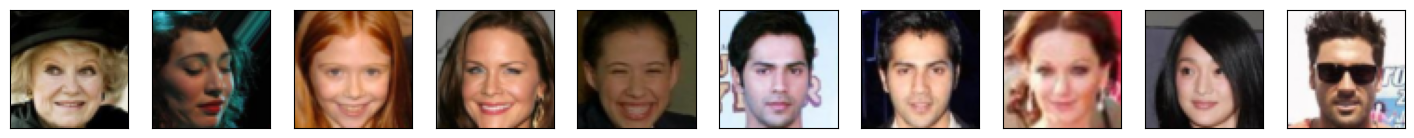

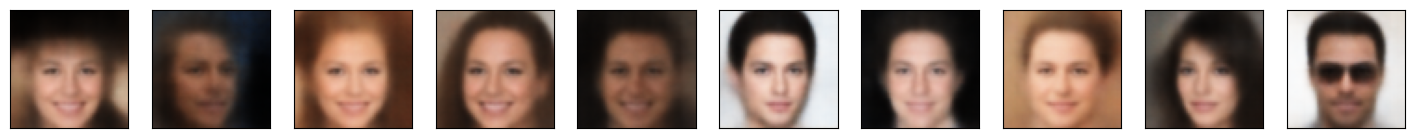

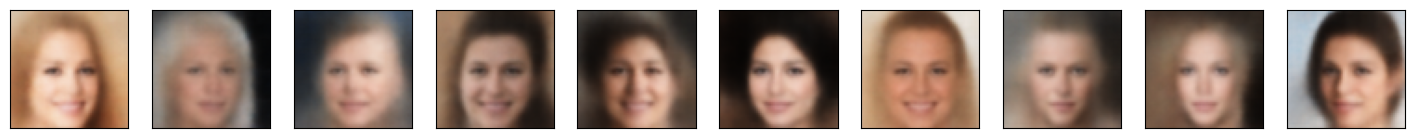

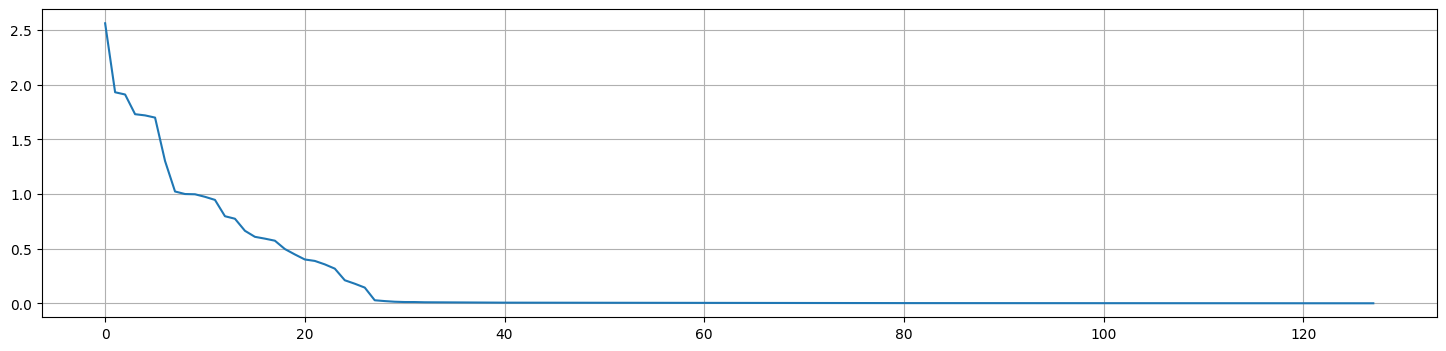

9001
kl_loss 24.87278938293457
recon_loss 0.013479931280016899
9002
kl_loss 26.169822692871094
recon_loss 0.0136732067912817
9003
kl_loss 25.291290283203125
recon_loss 0.013227825984358788
9004
kl_loss 24.73936653137207
recon_loss 0.013878125697374344
9005
kl_loss 26.06698989868164
recon_loss 0.01401625107973814
9006
kl_loss 25.63146209716797
recon_loss 0.013450231403112411
9007
kl_loss 26.010425567626953
recon_loss 0.013608800247311592
9008
kl_loss 26.4600887298584
recon_loss 0.013479921035468578
9009
kl_loss 25.621967315673828
recon_loss 0.012974712997674942
9010
kl_loss 25.434310913085938
recon_loss 0.013048472814261913
9011
kl_loss 25.71170997619629
recon_loss 0.01360990758985281
9012
kl_loss 25.59769058227539
recon_loss 0.013433358632028103
9013
kl_loss 25.700927734375
recon_loss 0.013382120057940483
9014
kl_loss 24.706064224243164
recon_loss 0.012587877921760082
9015
kl_loss 25.66997528076172
recon_loss 0.013607442378997803
9016
kl_loss 26.040870666503906
recon_loss 0.01428017392

9132
kl_loss 26.621871948242188
recon_loss 0.013793891295790672
9133
kl_loss 26.47252655029297
recon_loss 0.013368852436542511
9134
kl_loss 25.42582893371582
recon_loss 0.013990568928420544
9135
kl_loss 25.267810821533203
recon_loss 0.013103021308779716
9136
kl_loss 25.71979331970215
recon_loss 0.01247955672442913
9137
kl_loss 24.99480438232422
recon_loss 0.013123556040227413
9138
kl_loss 26.46884536743164
recon_loss 0.013463236391544342
9139
kl_loss 26.058271408081055
recon_loss 0.013706597499549389
9140
kl_loss 25.61807632446289
recon_loss 0.013100950047373772
9141
kl_loss 24.969276428222656
recon_loss 0.012627745978534222
9142
kl_loss 26.326356887817383
recon_loss 0.013184061273932457
9143
kl_loss 25.517105102539062
recon_loss 0.013887017965316772
9144
kl_loss 25.761510848999023
recon_loss 0.013837567530572414
9145
kl_loss 25.643203735351562
recon_loss 0.013547450304031372
9146
kl_loss 25.20067596435547
recon_loss 0.013637385331094265
9147
kl_loss 25.089614868164062
recon_loss 0.013


KeyboardInterrupt



In [27]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=1024)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=1024)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = model.prior.sample(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            kls = torch.sort(data['kl'].mean(dim=0), descending=True).values.data.cpu().numpy()
            plt.figure(figsize=[18, 4])
            plt.plot(kls)
            plt.grid()
            plt.show()    
                
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [11]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done


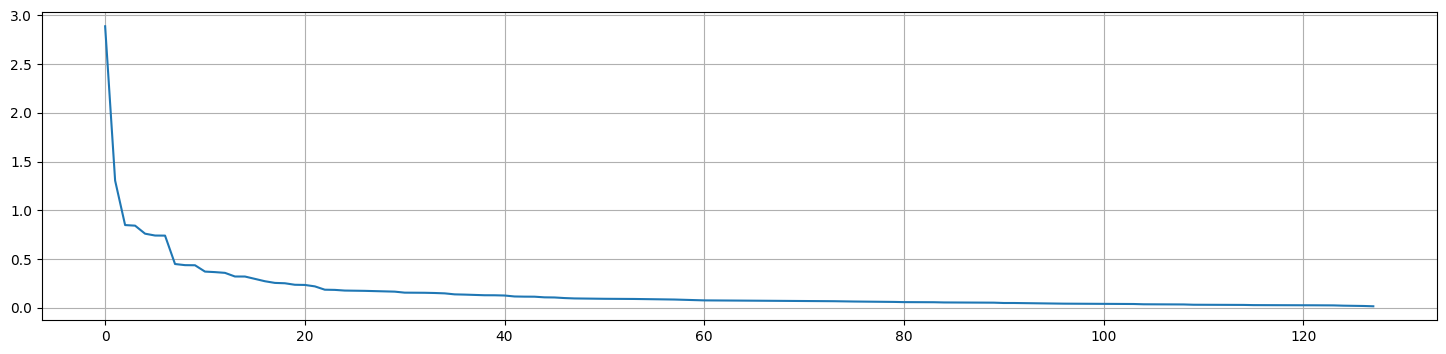